In [1]:
import networkx as nx 
import numpy as np
from make_graph import construct_graph_from_file
import geopandas as gpd
import shapefile as shp
import matplotlib.pyplot as plt
import queue
import random
from tqdm import tqdm_notebook as tqdm
from iowa_helper import capy_edge, capy_half, draw_state, valid_one_cluster, valid_isolated_config



%matplotlib inline

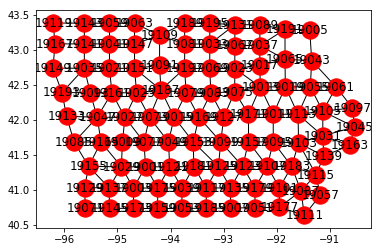

In [2]:
# read in shapefile and construct the dual graph of iowa

shapefile = 'goodiowa.shp'
g = construct_graph_from_file(shapefile, 'GEOID10', ['DP0010001'])

# get positional data to plot graph of iowa

# get the centroids of the counties
df_county = gpd.read_file(shapefile)
county_centroids = df_county.centroid
county_x = county_centroids.x
county_y = county_centroids.y

# this is just a way to map node id to index in the list
# i.e. inverse is a dictionary indexed by node id that gives the corresponding index in the county centroid list
inverse = {}
sf = shp.Reader(shapefile)
for i in range(len(sf.fields)):
    if sf.fields[i][0] == 'GEOID10':
        idx = i-1
        break
records = sf.records()
for i in range(len(records)):
    inverse[records[i][idx]] = i

# make the position dictionary keyed by node, this is used to plot the dual graph
pos = {}
count = 0 
for node in g.nodes():
    pos[node] = (county_x[inverse[node]], county_y[inverse[node]])
    count += 1
    
# plot graph to verify
nx.draw_networkx(g, pos=pos, with_labels=True)
plt.show()

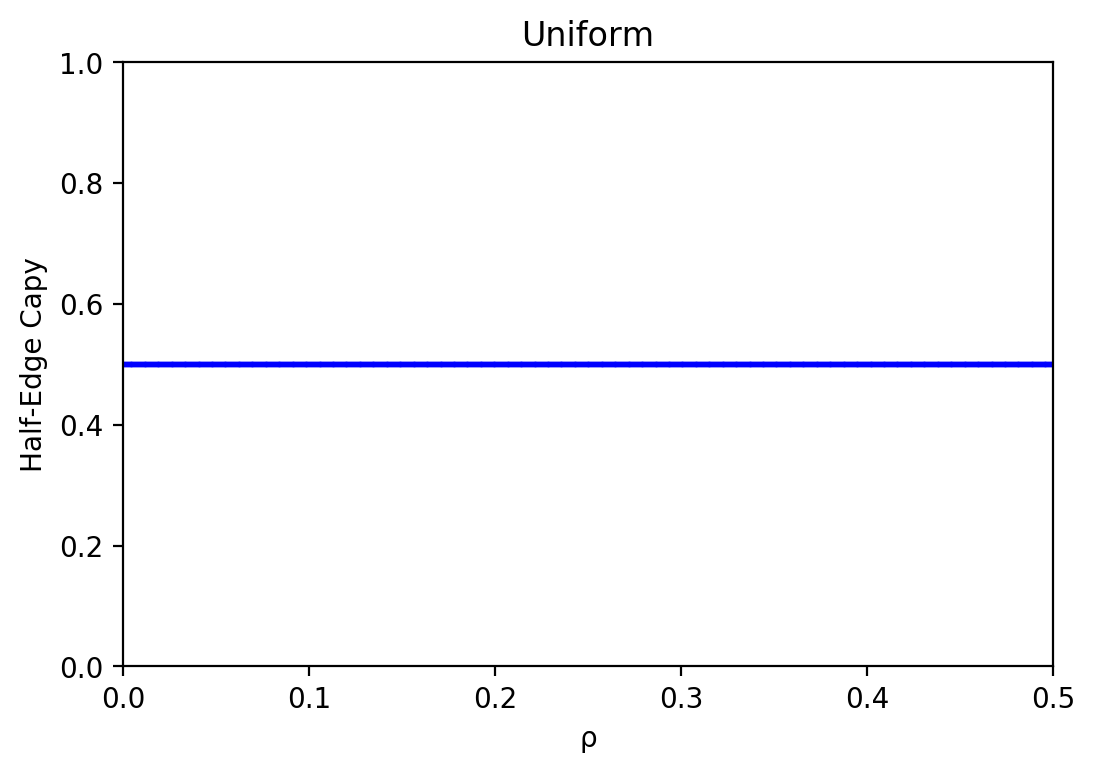

In [3]:
## generate the uniform confiuguration for many different rhos 
num_rhos = 1000

rhos = np.linspace(0.0001,0.5, num_rhos)
A = nx.to_numpy_array(g)

# data lists for scores
hcaps = np.zeros(num_rhos)
ecaps = np.zeros(num_rhos)

# population vectors
xvec = np.zeros((g.number_of_nodes(),1))
yvec = np.zeros((g.number_of_nodes(),1))

for i in range(num_rhos):
    j=0
    for node in g.nodes():
        xvec[j] = rhos[i]*g.node[node]['DP0010001']
        yvec[j] = (1-rhos[i])*g.node[node]['DP0010001']
        j += 1
    hcaps[i] = capy_half([xvec,yvec],A)
    ecaps[i] = capy_edge([xvec, yvec], A)
   
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(111)

ax1.scatter(rhos,hcaps,s=1,c='b')
ax1.set_xlabel(u"\u03C1")
ax1.set_xlim([0,0.5])
ax1.set_ylim([0,1])
ax1.set_ylabel('Half-Edge Capy')
ax1.set_title('Uniform')
'''

ax2.scatter(rhos,ecaps,s=1,c='b')
ax2.set_xlabel(u"\u03C1")
ax2.set_ylabel('Capy Score')
ax2.set_title('Edge Capy vs \u03C1')
'''
plt.show()

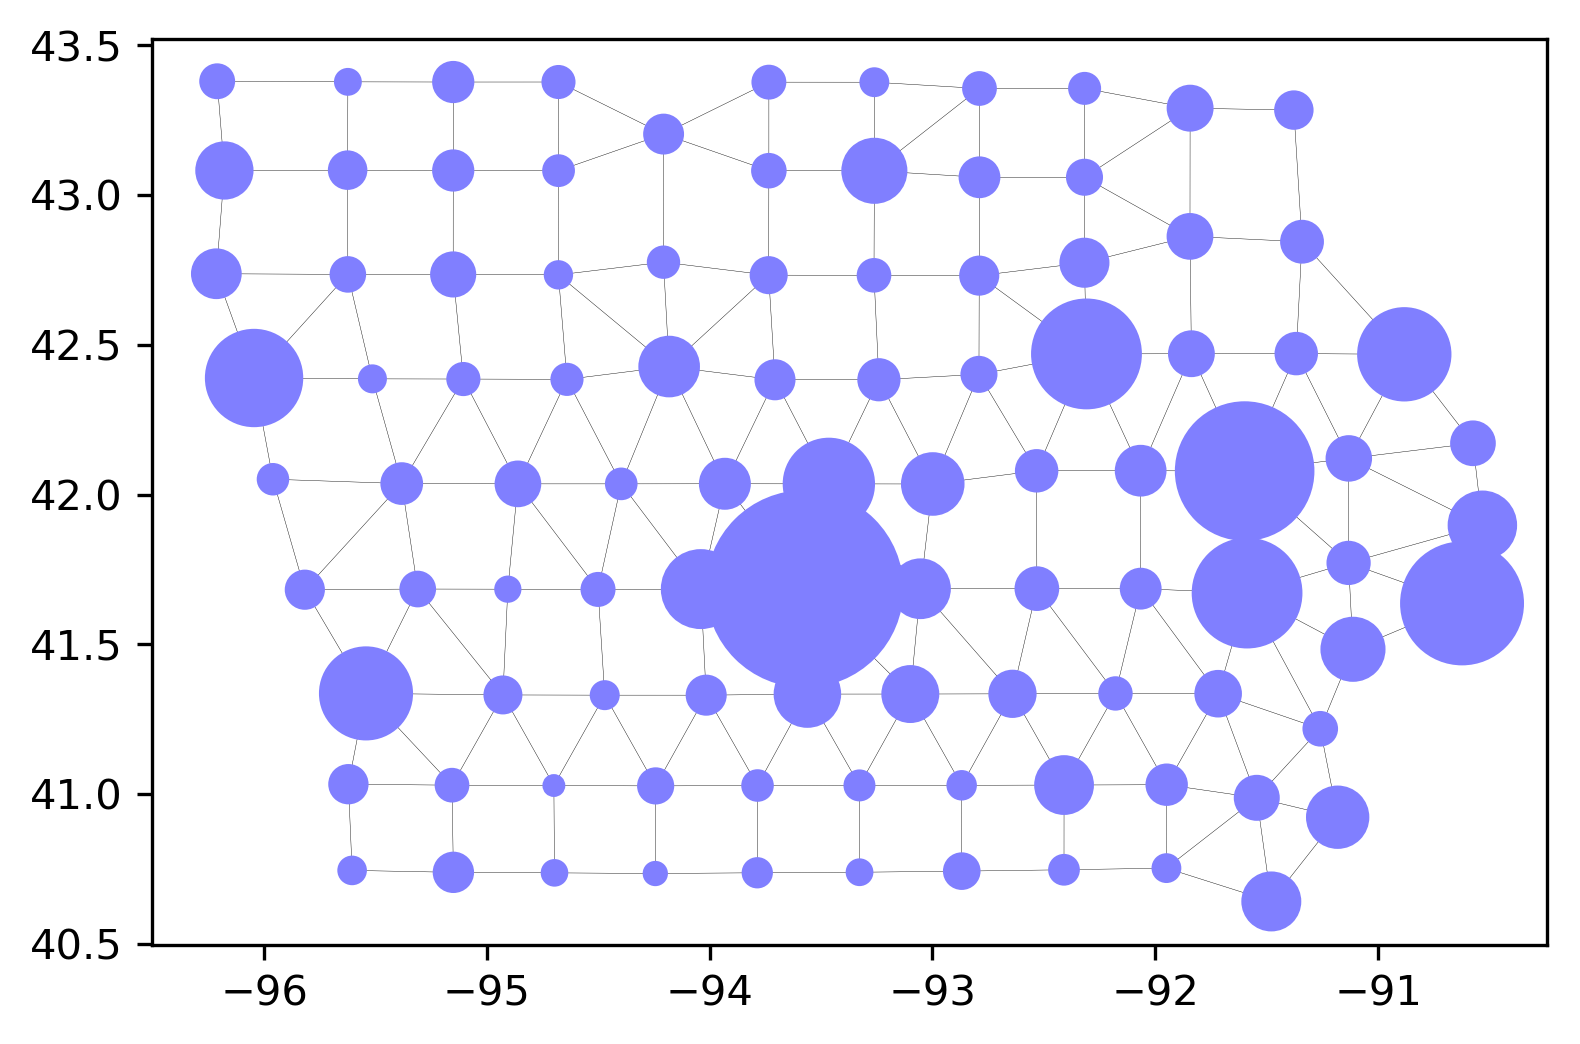

In [4]:
# draw last made uniform cluster
xvec = np.reshape(xvec, (xvec.size))
yvec = np.reshape(yvec, (yvec.size))
node_size = [(xvec[i] + yvec[i])/200 for i in range(g.number_of_nodes())]

draw_state(g, xvec, yvec, pos, node_size)


1669



4950 6619


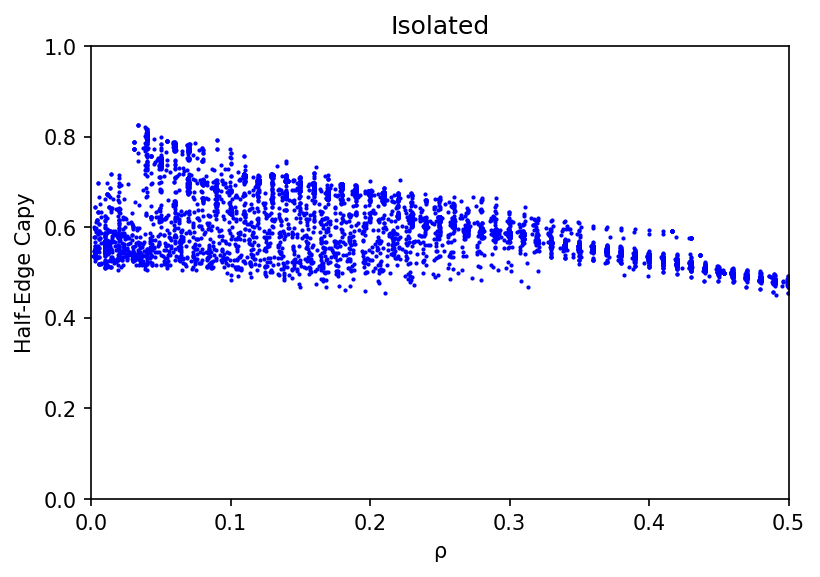

In [5]:
## isolated

# to plot the edge capy score instead of half edge uncomment all references to ax1 and comment those to ax2
fig = plt.figure(dpi=150)
#ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

num_samples = 100
num_rhos = 50
total_pop = 0
num_sampled = 0

# get a dictionary to translate node id to index in the list
i = 0
node_to_i = {}
for node in g.nodes():
    node_to_i[node] = i
    i+=1
    total_pop += g.node[node]['DP0010001']
        
# first sampling method, randomly generate isolated clusters
# loop however many times you want to sample each rho
for _ in tqdm(range(num_samples)):
    
    rhos = np.linspace(0.001,0.5, num_rhos)
    A = nx.to_numpy_array(g)
    hcaps = []
    ecaps = []
    real_rhos = []
    
    # sample a configuration at each rho
    for i in range(num_rhos-1):
        xvec = np.zeros((g.number_of_nodes(),1))
        yvec = np.zeros((g.number_of_nodes(),1))
        
        reject = True
        
        # mark nodes as not visited
        for node in g.nodes():
            g.node[node]['visited'] = False
        num_x = 0
        tot_num_x = int(rhos[i]*total_pop)
        
        # shuffle nodes to go through them randomly
        nodes= list(g.nodes())
        random.shuffle(nodes)
            
        #
        for node in nodes:
            if g.node[node]['visited']:
                continue
            g.node[node]['visited'] = True
        

            # check that none of the neighbors were visited
            neighbors_empty = True
            for nb in g.neighbors(node):
                if g.node[nb]['visited']:
                    neigbors_empty = False
                    break

            # skip the node since creating it would break the isolation requirements
            if not neighbors_empty:
                continue

            # mark neighbors as visited to keep node isolated
            for nb in g.neighbors(node):
                g.node[nb]['visited'] = True

            # set population of population x
            xvec[node_to_i[node]] = g.node[node]['DP0010001']
            num_x += g.node[node]['DP0010001']
                
            # if in the target rho range, accept the configuration
            if rhos[i] <= num_x/total_pop < rhos[i+1]:
                reject = False
                break

            # check if no more valid placements, break if none
            invalid = True
            for n in g.nodes():
                invalid = invalid and g.node[n]['visited']
            if invalid:
                break        
        
        # dont add data point if not in target rho range
        if reject:
            continue
            
        # make sure config is valid
        if not valid_isolated_config(g, xvec):
            print("invalid configuration")
            continue
            
        # add population to y vector
        for node in g.nodes():
            yvec[node_to_i[node]] = g.node[node]['DP0010001'] - xvec[node_to_i[node]][0]

        # get scores data
        ecaps.append(capy_edge([xvec, yvec], A))
        hcaps.append(capy_half([xvec, yvec], A))
        real_rhos.append(np.sum(xvec)/(np.sum(xvec+yvec)))
        
        
    #ax1.scatter(real_rhos,ecaps, c='b', s=1)
    ax2.scatter(real_rhos,hcaps, c='b', s=1)
    
    # count the number of data points actually sampled
    num_sampled += len(real_rhos)
    
old_num_sampled = num_sampled
print("number sampled randomly", num_sampled)
tot_pop_vec = np.zeros(g.number_of_nodes())

# second sampling method, start with each node and then start adding nodes based on population
# i.e. greedily make max population isolated configurations
i=0
i_to_node = {}
node_to_i = {}
for node in g.nodes:
    tot_pop_vec[i] = g.node[node]['DP0010001']
    i_to_node[i] = node
    node_to_i[node] = i
    g.node[node]['visited'] = False
    i+=1
    
# get sorted index list
sorted_indexes = np.flip(np.argsort(tot_pop_vec))
for rho in tqdm(np.linspace(0.01,0.5,50)):
    target_pop = rho*np.sum(tot_pop_vec)
    for k in range(g.number_of_nodes()):
        # initialize data

        curr_pop = 0
        xvec = np.zeros((g.number_of_nodes(),1))
        yvec = np.zeros((g.number_of_nodes(),1))

        # start with (k+1)th largest node
        xvec[sorted_indexes[k]] += tot_pop_vec[sorted_indexes[k]]
        in_config = []
        in_config.append(i_to_node[sorted_indexes[k]])

        for i in range(g.number_of_nodes()):
            if i == k:
                continue
            # check that proposed node is not a neighbor
            valid = True
            for node in in_config:
                for nb in g.neighbors(node):
                    if nb == i_to_node[sorted_indexes[i]]:
                        valid = False
            curr_pop = np.sum(xvec)          
            if valid and tot_pop_vec[sorted_indexes[i]] + curr_pop < target_pop:
                xvec[sorted_indexes[i]] += tot_pop_vec[sorted_indexes[i]]
                in_config.append(i_to_node[sorted_indexes[i]])

        # make sure config is valid
        if not valid_isolated_config(g, xvec):
            print("invalid configuration")
            continue

        # get complementary population vector
        for node in g.nodes():
            yvec[node_to_i[node]] = g.node[node]['DP0010001'] - xvec[node_to_i[node]]

        ax2.scatter([np.sum(xvec)/np.sum(tot_pop_vec)],[capy_half([xvec, yvec], A)], c='b', s=1)
        num_sampled += 1

print("number sampled greedily",num_sampled-old_num_sampled, "total num sampled", num_sampled)
'''
ax1.set_xlabel(u'\u03C1')
ax1.set_ylabel('Edge Capy Score')
ax1.set_title('Isolated')
'''
ax2.set_xlabel(u'\u03C1')
ax2.set_ylabel('Half-Edge Capy')
ax2.set_title('Isolated')
ax2.set_ylim([0,1])
ax2.set_xlim([0,0.5])

plt.show()

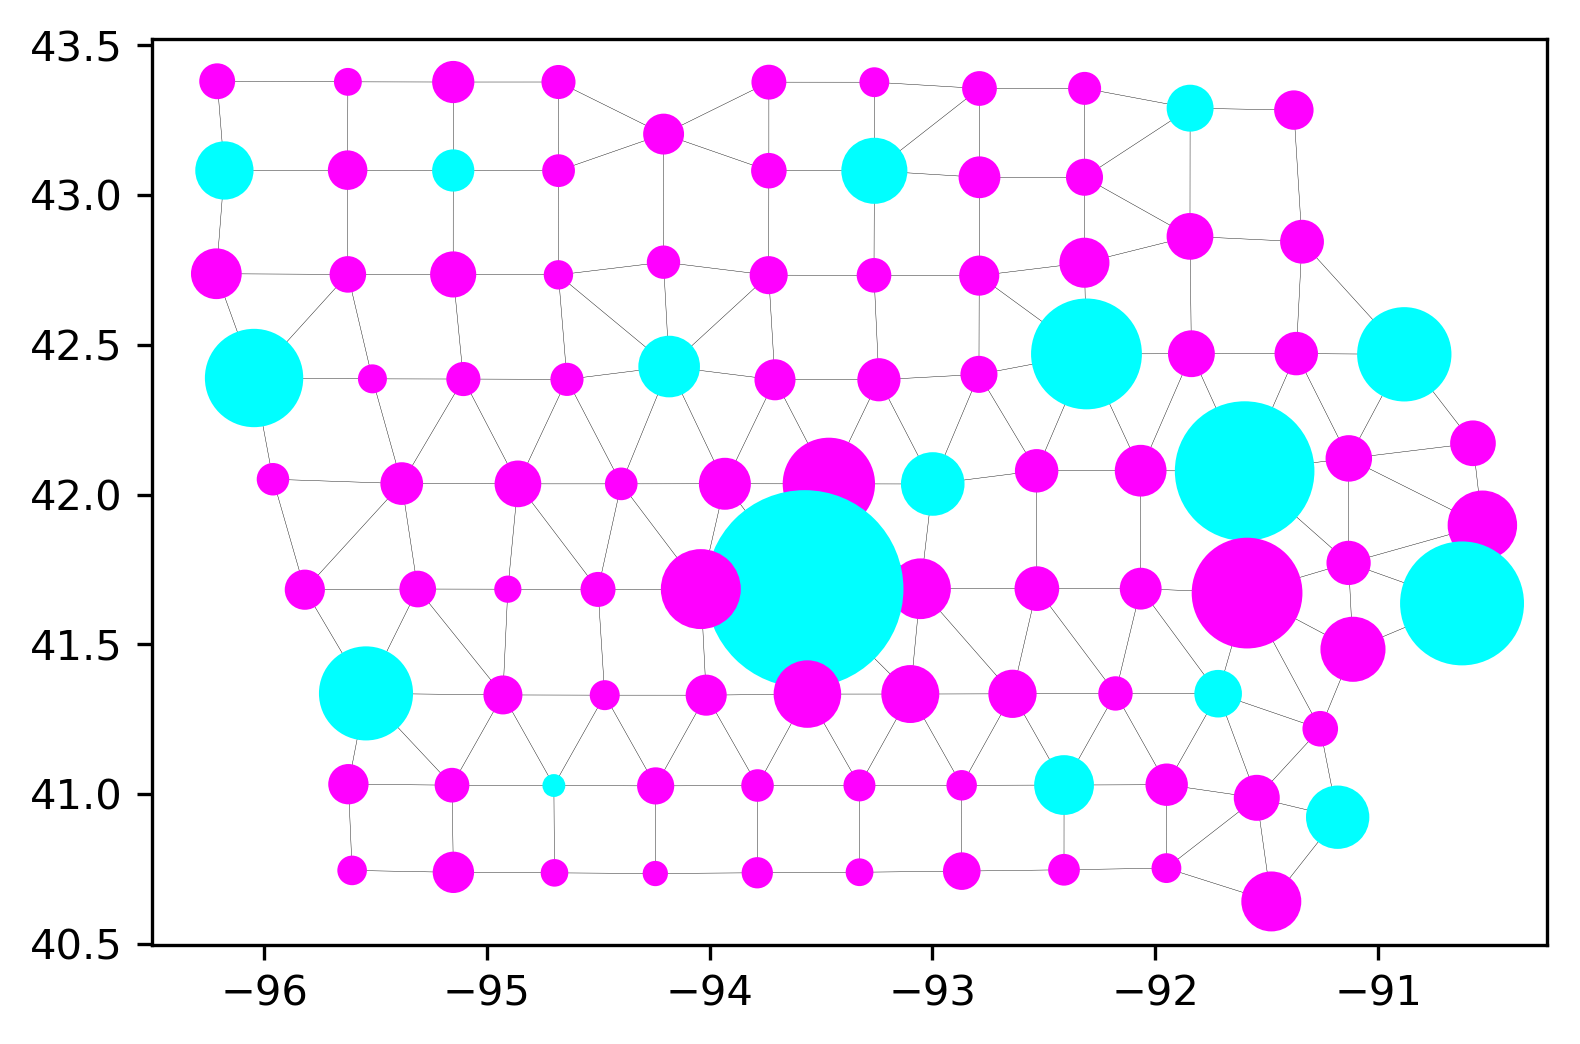

In [6]:
# draw the last made isolated configuration
xvec = np.reshape(xvec, (xvec.size))
yvec = np.reshape(yvec, (yvec.size))
node_size = [(xvec[i] + yvec[i])/200 for i in range(g.number_of_nodes())]

draw_state(g, xvec, yvec, pos, node_size)


num_sampled 3000


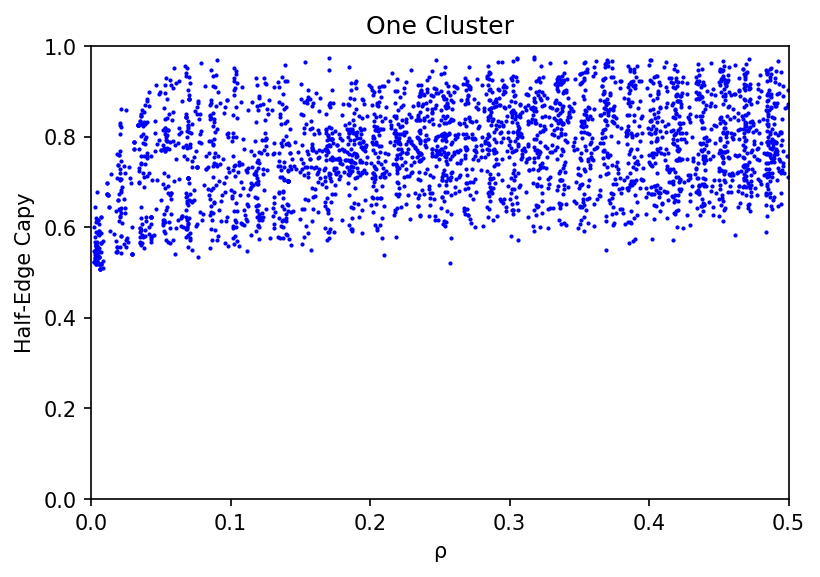

In [24]:
## one cluster

# to plot the edge capy score instead of half edge uncomment all references to ax1 and comment those to ax2

fig = plt.figure(dpi=150)
#ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
num_samples = 100
num_rhos = 31
total_pop = 0
i = 0
node_to_i = {}
num_sampled = 0
for node in g.nodes():
    node_to_i[node] = i
    i+=1
    total_pop += g.node[node]['DP0010001']
        
# loop as many times as you want to collect points at each target rho range
for _ in tqdm(range(num_samples)):
    
    rhos = np.linspace(0.001,0.5, num_rhos)
    A = nx.to_numpy_array(g)
    hcaps = []
    ecaps = []
    real_rhos = []
    
    for i in range(num_rhos-1):
        xvec = np.zeros((g.number_of_nodes(),1))
        yvec = np.zeros((g.number_of_nodes(),1))
        
        reject = True
        
        # keep track of nodes not in cluster 
        nodes_not_in_cluster = []
        for node in g.nodes():
            nodes_not_in_cluster.append(node)
            g.node[node]['in_cluster'] = False
            
        num_x = 0
        tot_num_x = int(rhos[i]*total_pop)
        nodes= list(g.nodes())
        random.shuffle(nodes)
        
        # pick a random node and grow one cluster by uniformly at random picking from the boundary of the cluster
        node = nodes[0]
        nodes_not_in_cluster.remove(node)
        g.node[node]['in_cluster'] = True
        xvec[node_to_i[node]] = g.node[node]['DP0010001']
        num_x += g.node[node]['DP0010001']
        boundary_nodes = []
        for nb in g.neighbors(node):
            boundary_nodes.append(nb)
            
        while len(boundary_nodes) > 0 and num_x < tot_num_x:  
            # pick boundary node uniformly at random
            node = random.choice(boundary_nodes)
            
            # only take nodes that don't overshoot the range
            if num_x + g.node[node]['DP0010001'] > 0.5*total_pop:
                boundary_nodes.remove(node)
                continue
                
            # check if adding node will cut other population
            nodes_not_in_cluster.remove(node)
            if nx.number_connected_components(g.subgraph(nodes_not_in_cluster)) != 1:
                # skip and pick another
                nodes_not_in_cluster.append(node)
                continue
                
            # add population
            xvec[node_to_i[node]] = g.node[node]['DP0010001']
            num_x += g.node[node]['DP0010001']
            g.node[node]['in_cluster'] = True
            
            # remove from boundary
            boundary_nodes.remove(node)
            
            # add neighbors to boundary list
            for nb in g.neighbors(node):
                if nb not in boundary_nodes and not g.node[nb]['in_cluster']:
                    boundary_nodes.append(nb)
        
        # make sure config is valid
        if not valid_one_cluster(g, xvec):
            print("invalid configuration")
            continue
        
        # add complementary population to y vector
        for node in g.nodes():
            yvec[node_to_i[node]] = g.node[node]['DP0010001'] - xvec[node_to_i[node]][0]

        # append scores and the actual rhos to lists for plotting
        ecaps.append(capy_edge([xvec, yvec], A))
        hcaps.append(capy_half([xvec, yvec], A))
        real_rhos.append(np.sum(xvec)/(np.sum(xvec+yvec)))
        
        
    #ax1.scatter(real_rhos,ecaps, c='b', s=1)
    ax2.scatter(real_rhos,hcaps, c='b', s=1)
    num_sampled += len(real_rhos)
    
'''
ax1.set_xlabel(u'\u03C1')
ax1.set_ylabel('Edge Capy Score')
ax1.set_title('Isolated')
'''
ax2.set_xlabel(u'\u03C1')
ax2.set_ylabel('Half-Edge Capy')
ax2.set_title('One Cluster')
ax2.set_ylim([0,1])
ax2.set_xlim([0,0.5])
print("num_sampled", num_sampled)

#plt.show()

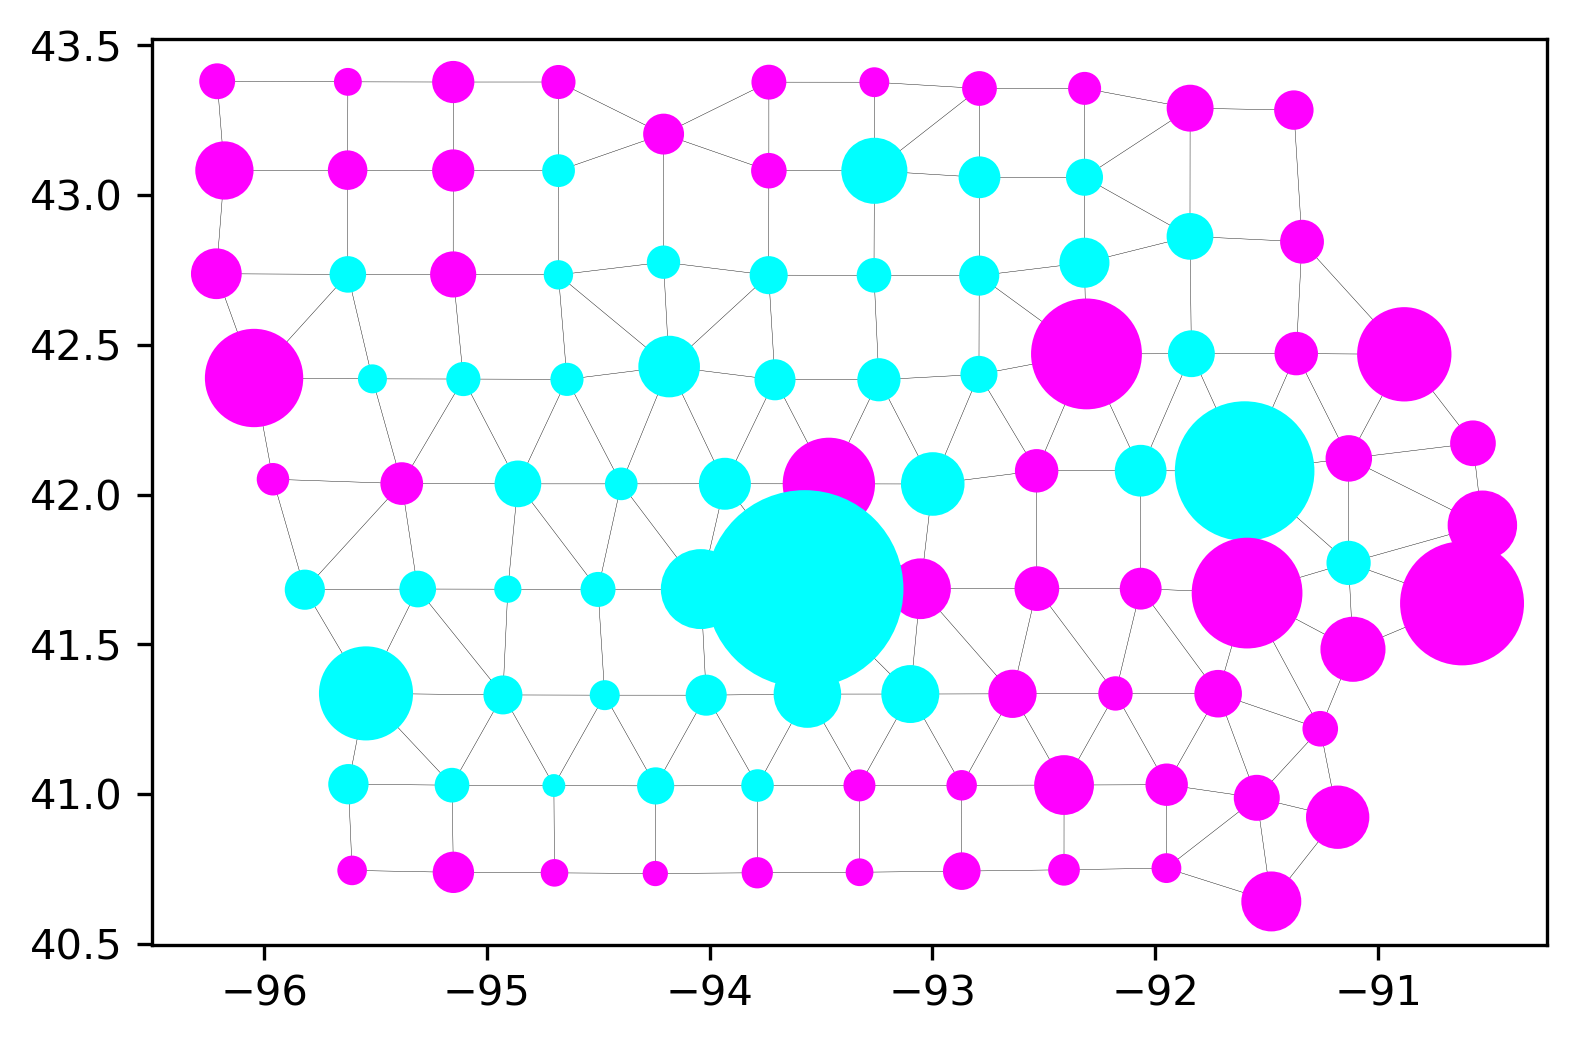

In [23]:
# draw last made one cluster
xvec = np.reshape(xvec, (xvec.size))
yvec = np.reshape(yvec, (yvec.size))
node_size = [(xvec[i] + yvec[i])/200 for i in range(g.number_of_nodes())]

draw_state(g, xvec, yvec, pos, node_size)